#### Wczytanie bibliotek

In [357]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, norm
from scipy.stats import jarque_bera
from statsmodels.sandbox.stats.runs import runstest_1samp
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA

#### Wczytanie danych z pliku csv

In [358]:
# Load the dataset
file_path = 'amd.csv'
data = pd.read_csv(file_path)

#### Obróbka danych

In [359]:
# Convert the Date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.0,3.302083,3.125000,3.145833,3.145833,219600
1,1980-03-18,0.0,3.125000,2.937500,3.031250,3.031250,727200
2,1980-03-19,0.0,3.083333,3.020833,3.041667,3.041667,295200
3,1980-03-20,0.0,3.062500,3.010417,3.010417,3.010417,159600
4,1980-03-21,0.0,3.020833,2.906250,2.916667,2.916667,130800


#### Logarytmiczne stopy zwrotu

In [360]:
# Obliczenie logarytmicznych cen zamknięcia
data['Log Adj Close'] = np.log(data['Adj Close'])

# Obliczenie logarytmicznej stopy zwrotu
data['Log Return'] = data['Log Adj Close'].diff()

# Wyczyszczenie logarytmicznych stóp zwrotu
clean_log_returns = data['Log Return'].dropna()

clean_log_returns.head()

1   -0.037104
2    0.003431
3   -0.010327
4   -0.031637
5   -0.089612
Name: Log Return, dtype: float64

- Date: The date of the observation.
- Open: The opening price of the stock on that day.
- High: The highest price of the stock on that day.
- Low: The lowest price of the stock on that day.
- Close: The closing price of the stock on that day.
- Adj Close: The adjusted closing price of the stock on that day.
- Volume: The number of shares traded on that day.
- Log return:

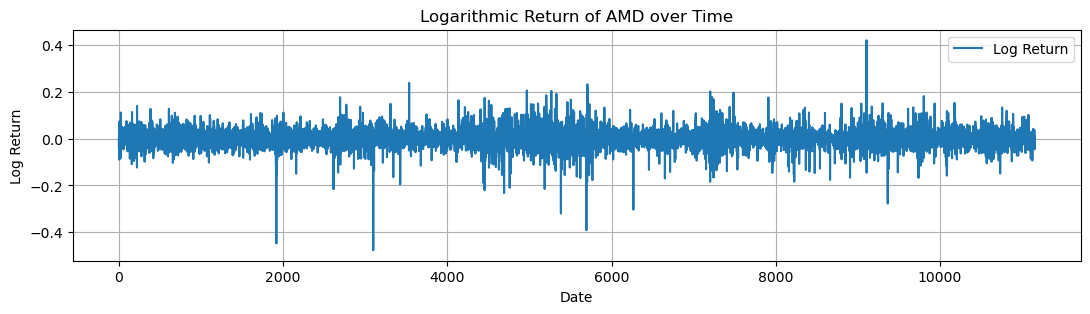

In [361]:
# Logarithmic Return of AMD
plt.figure(figsize=(13, 3))
plt.plot(clean_log_returns, label='Log Return')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.title('Logarithmic Return of AMD over Time')
plt.legend()
plt.grid(True)
plt.show()

In [362]:
clean_log_returns.describe()

count    11153.000000
mean         0.000352
std          0.037390
min         -0.476924
25%         -0.018605
50%          0.000000
75%          0.019418
max          0.420617
Name: Log Return, dtype: float64

#### Normalność rozkładu

In [363]:
n = clean_log_returns.count()
n_sqr = int(np.sqrt(n))
n_log = int(np.log(n))

print(f'n_sqr: {n_sqr},\nn_log: {n_log}')

n_sqr: 105,
n_log: 9


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


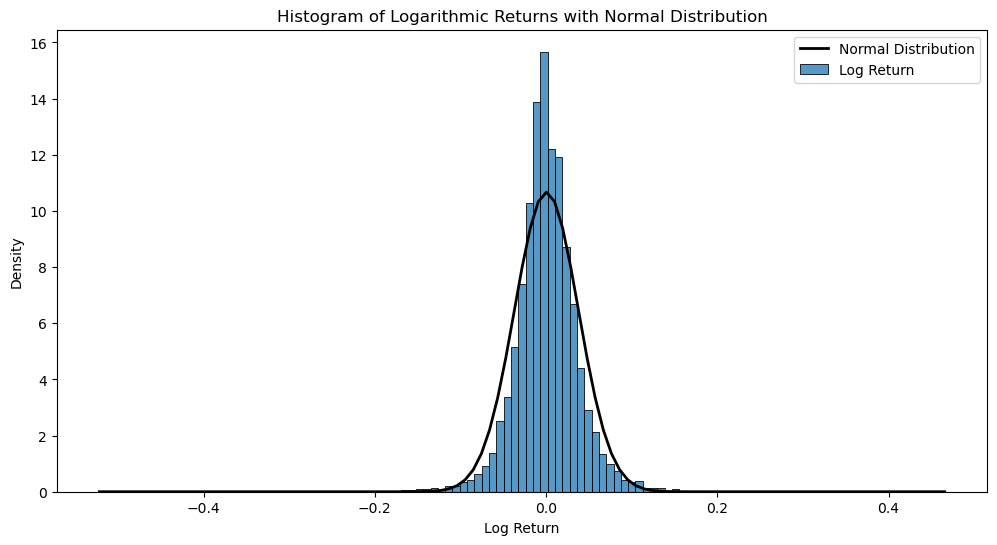

In [364]:
# Histogram logarytmicznych stóp zwrotu
plt.figure(figsize=(12, 6))
sns.histplot(clean_log_returns, bins=n_sqr, kde=False, stat='density', label='Log Return')

# Krzywa normalnego rozkładu
mean = clean_log_returns.mean()
std_dev = clean_log_returns.std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, n_sqr)
p = norm.pdf(x, mean, std_dev)
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')

plt.xlabel('Log Return')
plt.ylabel('Density')
plt.title('Histogram of Logarithmic Returns with Normal Distribution')
plt.legend()
plt.show()

In [365]:
# Obliczenie kurtozy logarytmicznych stóp zwrotu
log_return_kurtosis = kurtosis(clean_log_returns, fisher=False)
log_return_kurtosis

13.902082995491703

In [366]:
# Przeprowadzenie testu Jarque-Bera
jb_test_stat, jb_p_value = jarque_bera(clean_log_returns)

print(f'JB Test Statistic: {jb_test_stat}')
print(f'JB Test p-value: {jb_p_value}')

JB Test Statistic: 55550.65598942148
JB Test p-value: 0.0


- H0: dane są realizacją z rozkładu normalnego		
- H1: dane nie są realizacją z rozkładu normalnego		

#### Losowość danych

In [367]:
# Przeprowadzenie testu serii
z_stat, p_value = runstest_1samp(clean_log_returns, correction=True)

print(f'Z-value: {z_stat}')
print(f'p-value: {p_value}')

Z-value: -2.72299069103352
p-value: 0.006469388075642191


- Hipoteza zerowa (H0): Dane są losowe.
- Hipoteza alternatywna (H1): Dane nie są losowe.

#### Autokorelacja

<Figure size 1000x500 with 0 Axes>

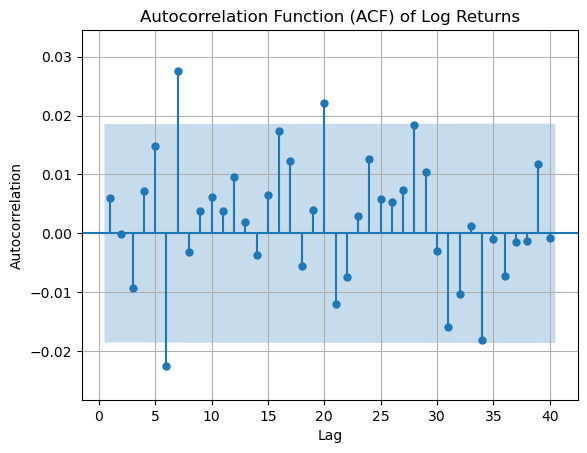

In [368]:
# Obliczenie ACF i stworzenie wykresu z dostosowaniem wizualnym
plt.figure(figsize=(10, 5))
plot_acf(clean_log_returns, lags=40, alpha=0.05, zero=False, auto_ylims=True)
plt.title('Autocorrelation Function (ACF) of Log Returns')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

In [369]:
# Przeprowadzenie testu Ljunga-Boxa
lb_test_results = acorr_ljungbox(clean_log_returns, lags=[n_log], return_df=True)
print(lb_test_results)

     lb_stat  lb_pvalue
9  18.911937   0.025952


#### ARIMA